In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import math


In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f'Using device {DEVICE}')

Using device cuda


In [3]:
import torch

print(f"PyTorch Version: {torch.__version__}")
print("---")
print(f"Is CUDA available? {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"PyTorch's Compiled CUDA Version: {torch.version.cuda}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"Current GPU Index: {torch.cuda.current_device()}")
    print(f"Current GPU Name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

PyTorch Version: 2.5.1+cu121
---
Is CUDA available? True
PyTorch's Compiled CUDA Version: 12.1
Number of GPUs: 1
Current GPU Index: 0
Current GPU Name: NVIDIA GeForce RTX 4050 Laptop GPU


In [4]:
img_size = 32
batch_size = 128

transforms = v2.Compose([
    v2.Resize((img_size, img_size)), # resize to 32*32
    v2.ToTensor(),
    v2.Lambda(lambda t:(t*2)-1) # change all the grid values into the range [-1.0, 1.0]
    ])

dataset = torchvision.datasets.CIFAR10(root='./data', download=True, transform=transforms)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)




c:\Users\nikhi\anaconda3\a\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Files already downloaded and verified


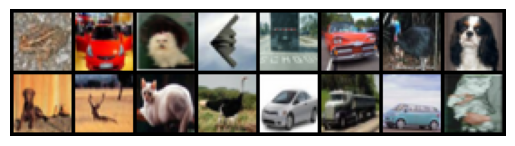

In [5]:
def show_img(images, title=""):
    images = (images+1) /2
    images = images.clamp(0, 1)

    grid_img = torchvision.utils.make_grid(images, nrow = 8)
    plt.imshow(grid_img.permute(1, 2, 0).cpu().numpy())
    plt.title(title)
    plt.axis('off')
    plt.show()


image_batch , _= next(iter(dataloader))
show_img(image_batch[:16])

In [6]:
timestamps = 300

def linear_beta_schedule(timestamps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timestamps)

betas = linear_beta_schedule(timestamps=timestamps) # this is variance schedule, defines amt of noise that is added till the timestamps

# alp = 1. - betas # amt of image content remain
# alphae_cumprod =  torch.cumprod(alp, axis=0) # total amt of image content/signal left after t-steps

# sqrt_alp_cumprod = torch.sqrt(alphae_cumprod)
# sqrt_one_minus_alp_cumprod = torch.sqrt(1. - alphae_cumprod)


alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def get_i_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,)*(len(x_shape)-1))).to(t.device)

def forward_diff_sample(x_0, t, device=DEVICE):
    noise = torch.randn_like(x_0)  # random noise with normal distribution

    # sqrt(alpha_cumprod) and sqrt(1 - alpha_cumprod) for the given timestep t
    sqrt_alphas_cumprod_t = get_i_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_i_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape)
    
    # Calculate the noisy image
    # mean + variance * noise
    noisy_image = (sqrt_alphas_cumprod_t.to(device)*x_0.to(device)) + (sqrt_one_minus_alphas_cumprod_t.to(device)*noise.to(device))

    return noisy_image, noise.to(device)



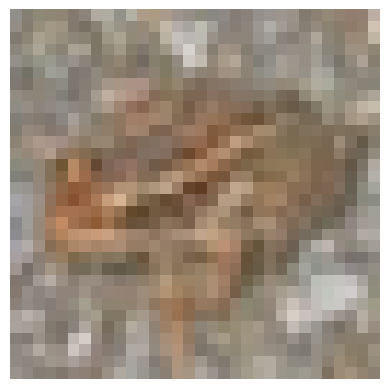

In [7]:
show_img(image_batch[0])

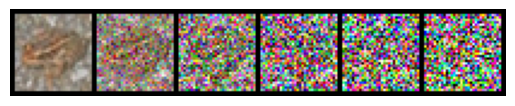

In [8]:
single_image = image_batch[0].unsqueeze(0)

# Define timesteps to visualize
timesteps_to_show = [0, 50, 100, 150, 199, 299]
noisy_images = []

# Generate noisy versions of the image at different timesteps
for t_val in timesteps_to_show:
    t = torch.tensor([t_val], dtype=torch.long)
    noisy_img, _ = forward_diff_sample(single_image, t)
    noisy_images.append(noisy_img)

# Concatenate for visualization
noisy_images_tensor = torch.cat(noisy_images, dim=0)

# Show the results
show_img(noisy_images_tensor)


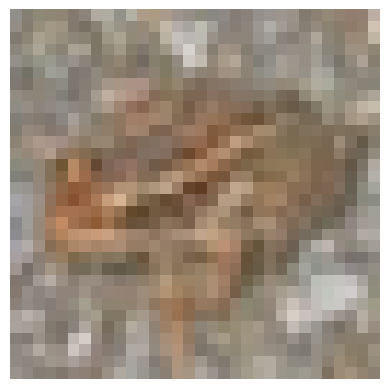

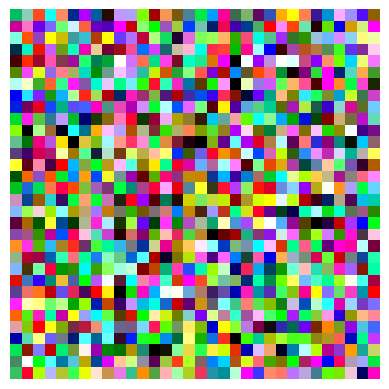

(None, None)

In [9]:
show_img(image_batch[0]), show_img(noisy_img)

### Why a U-Net?
- Symmetrical Structure: It has a downsampling path (encoder) to capture contextual information and an upsampling path (decoder) to reconstruct the image.

- Skip Connections: It connects layers from the downsampling path directly to corresponding layers in the upsampling path. This is crucial as it allows the model to reuse high-resolution feature maps from the early layers, helping it reconstruct fine details in the output.

In [10]:
class SPE(nn.Module): # sinusoidal PE that is used in OG Trnasformer paper
    '''
    Instead of just telling the artist "the noise level is 150", the assistant gives them a rich description:
    "This noise level is medium-high, which means you should focus on finding large shapes rather than fine textures, 
    and the color palette might be washed out."
    '''
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time): # inputs time(number) and converts it into embedding that contains rich features(time embedding)
        device = time.device

        half_dim = self.dim // 2

        embedding = math.log(10000)/(half_dim-1)
        embedding = torch.exp(torch.arange(half_dim, device=DEVICE)*-embedding)
        embedding = time[:, None] * embedding[None, :]
        embedding = torch.cat((embedding.sin(), embedding.cos()), dim=-1)
        return embedding
    
class Block(nn.Module): # bulding block of U-net
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)

        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)

        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.norm1=nn.GroupNorm(8, out_ch)
        self.norm2=nn.GroupNorm(8, out_ch)
        self.silu = nn.SiLU()

    def forward(self, x, t): # x - current state, t - noise level
        h = self.norm1(self.silu(self.conv1(x))) # convolve to activation fxn to normalisation

        time_emb = self.silu(self.time_mlp(t))
        time_emb = time_emb.unsqueeze(-1).unsqueeze(-1) # Reshape to (B, C, 1, 1)
        
        # Add time embedding
        h = h + time_emb # understanding of image + understand of noise level, they way it will paint will vary
        
        # Second convolution
        h = self.norm2(self.silu(self.conv2(h)))
        
        # Downsample or Upsample, depends on weather to zoom in and work on details....or zoom out and see the bigger picture
        return self.transform(h)


class UnetArch(nn.Module): 
    def __init__(self, image_channels=3, time_emb_dim=32, num_classes=10):
        super().__init__()
        
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        
        # Time embedding
        self.time_mlp = nn.Sequential(
            SPE(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )
        

        self.label_emb = nn.Embedding(num_classes+1, time_emb_dim)

        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsampling path
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], time_emb_dim) for i in range(len(down_channels)-1)]) 
        
        # Upsampling path
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], time_emb_dim, up=True) for i in range(len(up_channels)-1)])
        
        # Final convolve layer
        self.output = nn.Conv2d(up_channels[-1], image_channels, 1)

    def forward(self, x, timestep, labels):# U shape analogy, downsampling(encoder)-> get more abstract feature out of the image through smaller and deeper sample
                                            # upsampling(decoder)  -> after undertanding the features, capturing/adding details back
                                            # Skip Connections     -> refering high-res images while upsampling images to get OG texture and edges
        # embed time
        t_emb = self.time_mlp(timestep)

        l_emb = self.label_emb(labels)
        combined_emb = t_emb + l_emb
        
        # initial convolution
        x = self.conv0(x)
        
        # downsampling path + save skip connections
        residual_inputs = []  # saving high-res residual images for later(skip connections)
        for down_block in self.downs:
            x = down_block(x, combined_emb)
            residual_inputs.append(x)
        
        # upsampling path + use skip connections
        for up_block in self.ups:
            residual_x = residual_inputs.pop()   #get the corresponding skip connection from the downsampling path

            # Concatenate the skip connection with the current feature map
            x = torch.cat((x, residual_x), dim=1)           
            x = up_block(x, combined_emb)
            
        return self.output(x)





In [11]:
model = UnetArch(num_classes=10).to(DEVICE)
print(f"Model architecture defined. Number of parameters: {sum(p.numel() for p in model.parameters()):,}")
model


Model architecture defined. Number of parameters: 62,439,235


UnetArch(
  (time_mlp): Sequential(
    (0): SPE()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (label_emb): Embedding(11, 32)
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm1): GroupNorm(8, 128, eps=1e-05, affine=True)
      (norm2): GroupNorm(8, 128, eps=1e-05, affine=True)
      (silu): SiLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  

In [22]:
import torch
import torch.nn as nn
from tqdm import tqdm

LEARNING_RATE = 1e-4
EPOCHS = 20
NUM_CLASSES = 10
p_conditional = 0.1

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.L1Loss() 

print("Starting Training...")
model.train() 

for epoch in range(EPOCHS):
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    
    for step, (images, labels) in enumerate(pbar):
        optimizer.zero_grad()

        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # sample a random timestep for each image in the batch.....We use a LongTensor because timesteps are integer indices.
        t = torch.randint(0, timestamps, (batch_size,), device=DEVICE).long()
        
        # add noise to the images to get x_t and the added noise (our target)
        x_t, noise = forward_diff_sample(images, t, DEVICE)
        

        # with probability p_uncond, we train unconditionally
        unconditional_mask = torch.rand(labels.shape[0]) < p_conditional  
        labels[unconditional_mask] = NUM_CLASSES # set this as NULL class token i.e. 10

        # print(f"Labels min: {labels.min()}, Labels max: {labels.max()}, Labels dtype: {labels.dtype}")


        # predict the noise using the U-Net......model is on the DEVICE, and x_t and t are already on the DEVICE
        predicted_noise = model(x_t, t, labels)
        
        # calculate the loss between the predicted noise and the actual noise
        loss = criterion(noise, predicted_noise)
        
        # backpropagate and update weights
        loss.backward()
        optimizer.step()
        
        # update the progress bar description with the current loss
        pbar.set_postfix(loss=f"{loss.item():.4f}")

print("Training finished.")
model_path = f"ddpm_cifar10_clf_free_{EPOCHS}_epochs.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Starting Training...


Epoch 20/20: 100%|██████████| 390/390 [01:37<00:00,  4.01it/s, loss=0.1546]


Training finished.
Model saved to ddpm_cifar10_clf_free_20_epochs.pth


C:\Users\nikhi\AppData\Local\Temp\ipykernel_19916\3414991052.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=D

Generating 16 images for class 7 with guidance strength 7.5...


Sampling loop: 100%|██████████| 300/300 [00:08<00:00, 36.93it/s]


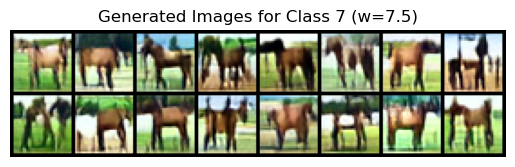

tensor([[[[ 0.7810,  0.9208,  0.9317,  ...,  0.7878,  0.8518,  0.8565],
          [ 0.5875,  0.9188,  0.9673,  ...,  0.8684,  0.9120,  0.8516],
          [ 0.2684,  0.7683,  0.8710,  ...,  0.8274,  0.8763,  0.6408],
          ...,
          [-0.1324, -0.1434, -0.1542,  ...,  0.0533,  0.0337,  0.0046],
          [-0.0691, -0.1173, -0.1801,  ...,  0.1596,  0.1322,  0.1879],
          [ 0.1422,  0.1846,  0.1819,  ...,  0.2479,  0.2261,  0.2697]],

         [[ 0.8228,  0.9383,  0.9806,  ...,  0.9246,  0.9830,  1.0490],
          [ 0.6323,  0.9793,  1.0168,  ...,  1.0052,  1.0598,  1.0310],
          [ 0.2970,  0.8029,  0.9280,  ...,  0.9791,  1.0758,  0.8383],
          ...,
          [ 0.2768,  0.2928,  0.2904,  ...,  0.3357,  0.3270,  0.2735],
          [ 0.3130,  0.2329,  0.1921,  ...,  0.3881,  0.3456,  0.3675],
          [ 0.4469,  0.4731,  0.5264,  ...,  0.3902,  0.3109,  0.3464]],

         [[ 0.7360,  0.8751,  0.9452,  ...,  0.9759,  1.0871,  1.0460],
          [ 0.5363,  0.9166,  

In [24]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision


@torch.no_grad()
def sample(model, num_images, class_label, guidance_strength=7.5):
    print(f"Generating {num_images} images for class {class_label} with guidance strength {guidance_strength}...")
    model.eval()
    
    img_shape = (num_images, 3, img_size, img_size)
    
    img = torch.randn(img_shape, device=DEVICE)
    
    labels = torch.full((num_images,), class_label, device=DEVICE, dtype=torch.long)
    uncond_labels = torch.full((num_images,), NUM_CLASSES, device=DEVICE, dtype=torch.long)

    for i in tqdm(reversed(range(0, timestamps)), desc='Sampling loop', total=timestamps):
        t = torch.full((num_images,), i, device=DEVICE, dtype=torch.long)
        
        conditional_noise = model(img, t, labels)
        unconditional_noise = model(img, t, uncond_labels) 
        
        predicted_noise = (1 + guidance_strength) * conditional_noise - guidance_strength * unconditional_noise 
        
        betas_t = get_i_from_list(betas, t, img.shape)
        sqrt_one_minus_alphas_cumprod_t = get_i_from_list(sqrt_one_minus_alphas_cumprod, t, img.shape)
        sqrt_recip_alphas_t = get_i_from_list(sqrt_recip_alphas, t, img.shape)
        
        model_mean = sqrt_recip_alphas_t * (img - betas_t * predicted_noise / sqrt_one_minus_alphas_cumprod_t)
        
        if i == 0:
            img = model_mean
        else:
            posterior_variance_t = get_i_from_list(posterior_variance, t, img.shape)
            noise = torch.randn_like(img)
            img = model_mean + torch.sqrt(posterior_variance_t) * noise
            
    model.train()
    show_img(img, f"Generated Images for Class {class_label} (w={guidance_strength})")
    return img


model = UnetArch(num_classes=10).to(DEVICE)
model_path = f"ddpm_cifar10_clf_free_{EPOCHS}_epochs.pth" 
model.load_state_dict(torch.load(model_path, map_location=DEVICE))

model.eval()

sample(model, num_images=16, class_label=7)